In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute, transpile, assemble
from qiskit.circuit import Parameter,ParameterVector
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import EfficientSU2
from qiskit.opflow import Z, X, I, StateFn, CircuitStateFn, SummedOp
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI, Hessian
from qiskit_machine_learning.circuit.library import RawFeatureVector
from sklearn.preprocessing import OneHotEncoder
from qiskit.algorithms.optimizers import SPSA, GradientDescent, QNSPSA, ADAM
import numpy as np
import itertools as itr
import matplotlib.pyplot as plt

COUNTER = 0
DIR_val_train = "Encode_data/amp_enc_data_set_trainning_values.csv"
DIR_cls_train = "Encode_data/amp_enc_data_set_trainning_classes.csv"

DIR_val_test = "Encode_data/amp_enc_data_set_test_values.csv"
DIR_cls_test = "Encode_data/amp_enc_data_set_test_classes.csv"

# Circuito

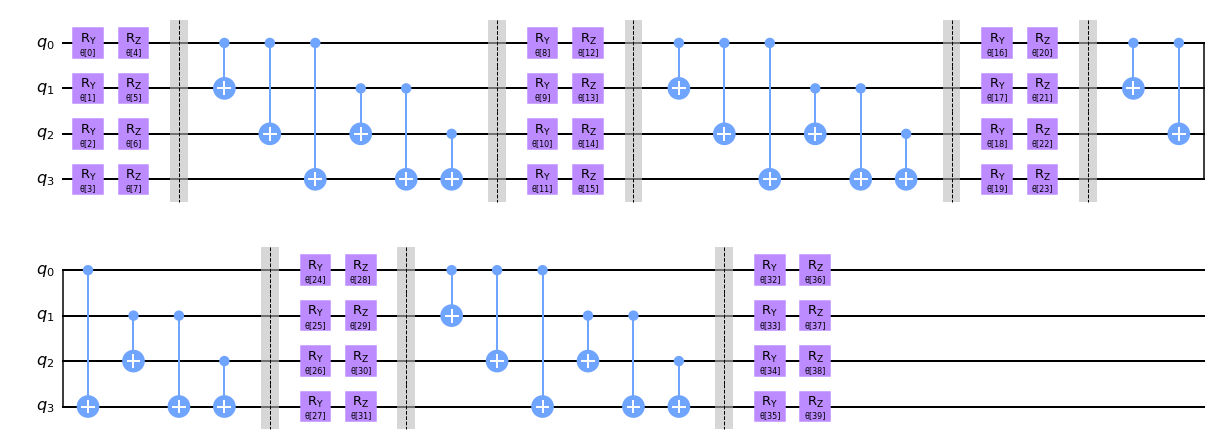

In [2]:
n_qubits = 4

encoding = RawFeatureVector(16)

ansatz = EfficientSU2(n_qubits, entanglement='full', reps=4, 
                        insert_barriers=True, name="U(\u03B8)", 
                        parameter_prefix="\u03B8")
ansatz.decompose()
qc = encoding.compose(ansatz)
qc.measure_all()
ansatz.decompose().draw(output="mpl")

In [3]:
def get_encode(file, type_ENC):

    """
    Funcao responsavel pelo encoding (amplitude)
    """
    if type_ENC.lower() == "amplitude":

        data_ENC = np.genfromtxt(file, delimiter=";")

    else:
        return None

    return data_ENC

In [4]:
train_data = get_encode(DIR_val_train, "amplitude")
train_labels = np.genfromtxt(DIR_cls_train, delimiter=";")

test_data = get_encode(DIR_val_test, "amplitude")
test_labels = np.genfromtxt(DIR_cls_test, delimiter=";")

In [5]:
def circuit_parameters(encoding, ansatz, x, thetas, self_encoding=False):
    parameters = {}
    if self_encoding:
        for i, p in enumerate(list(encoding.parameters)):
            parameters[p] = x[i]
    else:
        for i, p in enumerate(list(encoding.ordered_parameters)):
            parameters[p] = x[i]
    for i, p in enumerate(ansatz.ordered_parameters):
        parameters[p] = thetas[i]
    return parameters

In [6]:
def train(qc, encoding, ansatz, train_data, train_labels, self_encoding=False, lr=None, initial_point=None):
        # Callback function for optimiser for plotting purposes
        def store_intermediate_result(evaluation, parameter, cost, 
                                stepsize, accept):
                evaluations.append(evaluation)
                parameters.append(parameter)
                costs.append(cost)

        # Set up the optimization

        parameters = []
        costs = []
        evaluations = []

        if lr is not None:
                optimizer = SPSA(maxiter=200 , learning_rate=lr, perturbation=0.01, callback=store_intermediate_result)
        else:
                optimizer = SPSA(maxiter=200, callback=store_intermediate_result)

        if initial_point is not None:
                initial_point = initial_point
        else:      
                initial_point = np.random.random(ansatz.num_parameters)

        objective_function = lambda variational: cost_function(qc,encoding, ansatz,
                train_data, train_labels, variational, self_encoding=self_encoding)
        
        # Run the optimization
        opt_var, opt_value, _ = optimizer.optimize(len(initial_point), objective_function, initial_point=initial_point)

        return opt_var, opt_value , parameters, costs, evaluations 

## Mean Square error

### Multi Qubit exp val

$$Cost() = \frac{1}{N}\sum (y-\hat{y})^2$$


In [7]:
train_labels_oh = train_labels
test_labels_oh = test_labels

In [8]:
def cost_function(qc, encoding, ansatz, X, Y, thetas, self_encoding=False):
    #thetas -> variational parameters
    #X dataset
    #Y labels

    #build circuits for each datapoint
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in X]
    
    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    predictions = [classification(results.get_counts(c)) for c in circuits]
    #print(predictions)
    cost = np.mean(np.array([loss_function(y,y_hat) for (y,y_hat) in zip(Y, predictions)]))
    print(f"Cost {cost}")
    return cost

In [9]:
#%%script echo skipping
def basis_states_probs(counts, shots=1024, decimal=False, n_qubits=1):
    
    """
    Retorna as probabilidades de cada estado
    """
    
    probs = []
   
    if decimal:
        basis_states = list(range(2**n_qubits))
    else:
        basis_states = [np.binary_repr(i,width=n_qubits) for i in range(2**n_qubits)]

    for b in basis_states:
        c = counts.get(b)
        if c is None:
            probs.append(0)
        else:
            probs.append(counts[b]/shots)
    
    return probs


def classification(counts, shots=1024, label=True):
    
    def count_ones(string):
        r = 0
        for char in string:
            if char == "1":
                r+=1
        return r
    
    def label_assign(exp_val):
        if exp_val >= 0:
            r = 1
        else:
            r = -1
        return r

    probs = basis_states_probs(counts, n_qubits=n_qubits)
    states = ["".join(seq) for seq in itr.product("01", repeat=n_qubits)]
    
    exp_val = 0
    for state, prob in zip(states, probs):
        #print(prob, state)
        exp_val += ((-1)**(count_ones(state)%2))*prob
    
    #print(f"Valor expectávlel {exp_val}, Label {label_assign(exp_val)} ")
    if label:
        #print(exp_val)
        return label_assign(exp_val)
    else:
        return exp_val
    
def loss_function(y,y_hat):
    #print(f"Loss {y}-{y_hat}**2")
    #print(f"Loss {(y-y_hat)**2}")
    return (y-y_hat)*(y-y_hat)

In [10]:
opt_var, opt_value , parameters, costs, evaluations = train(qc, encoding, ansatz, train_data, train_labels_oh, self_encoding=True)

Cost 2.1
Cost 2.5
Cost 2.5
Cost 2.6
Cost 2.0
Cost 2.0
Cost 2.55
Cost 2.0
Cost 2.0
Cost 2.2
Cost 2.15
Cost 2.0
Cost 2.2
Cost 2.0
Cost 2.15
Cost 1.85
Cost 1.85
Cost 3.0
Cost 2.0
Cost 2.7
Cost 1.6
Cost 2.65
Cost 2.0
Cost 2.05
Cost 3.25
Cost 2.65
Cost 2.45
Cost 2.05
Cost 2.25
Cost 2.1
Cost 2.25
Cost 2.1
Cost 2.05
Cost 2.5
Cost 2.15
Cost 2.0
Cost 2.1
Cost 2.6
Cost 2.2
Cost 2.1
Cost 2.85
Cost 2.1
Cost 3.4
Cost 1.6
Cost 2.75
Cost 2.5
Cost 2.0
Cost 2.8
Cost 2.15
Cost 2.0
Cost 3.05
Cost 1.55
Cost 2.75
Cost 2.75
Cost 2.4
Cost 2.45
Cost 2.0
Cost 2.05
Cost 2.55
Cost 2.25
Cost 2.05
Cost 2.05
Cost 2.8
Cost 1.95
Cost 1.9
Cost 2.2
Cost 1.95
Cost 2.0
Cost 2.0
Cost 1.3
Cost 2.0
Cost 3.1
Cost 2.05
Cost 3.35
Cost 3.65
Cost 3.45
Cost 3.35
Cost 3.65
Cost 2.05
Cost 2.0
Cost 2.0
Cost 2.0
Cost 2.0
Cost 2.0
Cost 2.0
Cost 2.0
Cost 2.0
Cost 1.15
Cost 1.65
Cost 1.8
Cost 1.45
Cost 1.6
Cost 2.0
Cost 1.2
Cost 0.65
Cost 1.9
Cost 0.5
Cost 1.9
Cost 2.0
Cost 1.35
Cost 1.4
Cost 1.35
Cost 1.35
Cost 1.3
Cost 0.65
Cost 2.0
C

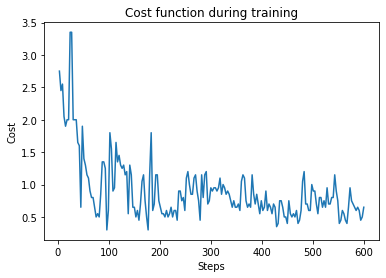

In [11]:
fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel("Steps")
plt.ylabel("Cost")
plt.title("Cost function during training")
plt.show()

In [12]:
def func_accuracy(data, labels, thetas, self_encoding=False):
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in data]
    #print(circuits)

    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    prediction = [classification(results.get_counts(c)) for c in circuits]
    #print(prediction)
    #print(labels)
    #prediction = [0 if p[0] > p[1] else 1 for p in probs]
    accuracy = 0
    print(labels)
    print(prediction)
    for i, p in enumerate(prediction):
        #if (p and labels[i]) or (not p and not labels[i]):
        if p == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, prediction

In [13]:
accuracy, prediction = func_accuracy(test_data, test_labels, opt_var, self_encoding=True)
print("Test set accuracy - {}".format(accuracy))

[-1. -1.  1. -1.  1. -1.  1. -1. -1.  1. -1.  1.  1. -1.  1.  1.  1.  1.
 -1. -1. -1. -1.  1.  1.]
[-1, -1, 1, -1, 1, -1, 1, -1, -1, -1, -1, 1, 1, -1, 1, 1, -1, 1, -1, -1, -1, -1, 1, -1]
Test set accuracy - 0.875


## Cross Entropy Loss

### Parity method

In [14]:
encoder = OneHotEncoder()
train_labels_oh = encoder.fit_transform(train_labels.reshape(-1, 1)).toarray()
test_labels_oh = encoder.fit_transform(test_labels.reshape(-1, 1)).toarray()

In [15]:
def parity_classification(counts, shots=1024):
    probs = np.zeros(2)
    for bitstring, counts in counts.items():
        hw_parity = hamming_weight_parity(bitstring)
        probs[hw_parity] += counts/shots
    
    return probs
def hamming_weight_parity(bitstring):
    hamming_weight = sum([int(k) for k in bitstring])
    return hamming_weight % 2

def loss_function(y,y_hat):
    #print(y_hat)
    return np.sum(y*np.log(y_hat))

In [16]:
def cost_function(qc, encoding, ansatz, X, Y, thetas, self_encoding=False):
    #thetas -> variational parameters
    #X dataset
    #Y labels

    #build circuits for each datapoint
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in X]

    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    predictions = [parity_classification(results.get_counts(c)) for c in circuits]
    
    cost = -np.mean(np.array([loss_function(y,y_hat) for (y,y_hat) in zip(Y, predictions)]))
    print(f"Cost: {cost}")
    
    return cost

In [17]:
opt_var, opt_value , parameters, costs, evaluations = train(qc, encoding, ansatz, train_data, train_labels_oh, self_encoding=True)

Cost: 0.6669420479651693
Cost: 0.7661244740569607
Cost: 0.703576179104024
Cost: 0.7543967861510641
Cost: 0.6564161314679847
Cost: 0.7103210163526884
Cost: 0.7724720352783734
Cost: 0.711633052931241
Cost: 0.7235002987330883
Cost: 0.767616831671126
Cost: 0.6831299722519879
Cost: 0.6358165052932703
Cost: 0.8035237951030169
Cost: 0.7735528007551643
Cost: 0.6983102948325832
Cost: 0.6470961151841852
Cost: 0.8115724779125122
Cost: 0.704223382691111
Cost: 0.6399325513382556
Cost: 0.7434801663299545
Cost: 0.7810036200972181
Cost: 0.6370597223068589
Cost: 0.744317350398697
Cost: 0.703620808512144
Cost: 0.6619956488633523
Cost: 0.675595240810615
Cost: 0.8451316515408733
Cost: 0.7192890478575871
Cost: 0.6742427257580992
Cost: 0.774879742559065
Cost: 0.761139107760835
Cost: 0.7123411190962
Cost: 0.6847572302645956
Cost: 0.6966384855046296
Cost: 0.7425615160522253
Cost: 0.6947731937740457
Cost: 0.7069056300620644
Cost: 0.7383891962265047
Cost: 0.6450314263839306
Cost: 0.7294292930171935
Cost: 0.6609

Cost: 0.521052754856886
Cost: 0.4834138077258876
Cost: 0.469967936473905
Cost: 0.48917951213611327
Cost: 0.49698047388634237
Cost: 0.4680093654009596
Cost: 0.5193885936159109
Cost: 0.49035360928057825
Cost: 0.4667833943524453
Cost: 0.48437837718381277
Cost: 0.5126831336016047
Cost: 0.46552152873177877
Cost: 0.5083506550347391
Cost: 0.485917542812979
Cost: 0.46511052942737263
Cost: 0.49839727347438173
Cost: 0.48341324420499043
Cost: 0.45874142756206765
Cost: 0.5320862302198615
Cost: 0.48700948402872796
Cost: 0.46232407594196234
Cost: 0.5177851102454728
Cost: 0.4915529168354965
Cost: 0.47141447544914816
Cost: 0.49625906348519944
Cost: 0.5024678023749489
Cost: 0.4657700819421116
Cost: 0.4975885896476335
Cost: 0.4978350219425895
Cost: 0.4669059204605742
Cost: 0.5127534633378847
Cost: 0.5036180287126646
Cost: 0.46505088641750625
Cost: 0.49422850635705756
Cost: 0.4904712095270953
Cost: 0.46666582912287674
Cost: 0.4934156070128578
Cost: 0.47841016817460547
Cost: 0.46008435096344247
Cost: 0.47

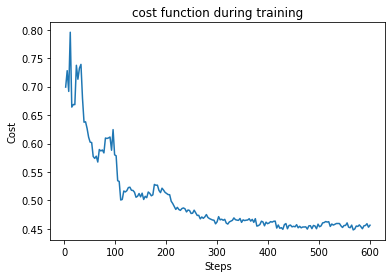

In [18]:
fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel("Steps")
plt.ylabel("Cost")
plt.title("cost function during training")
plt.show()

In [19]:
def func_accuracy(data, labels, thetas, self_encoding=False):
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in data]

    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    probs = [parity_classification(results.get_counts(c)) for c in circuits]
    prediction = [-1 if p[0] > p[1] else 1 for p in probs]
    accuracy = 0
    print(labels)
    print(prediction)
    for i, p in enumerate(prediction):
        if p == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, prediction

In [20]:
accuracy, prediction = func_accuracy(test_data, test_labels, opt_var, self_encoding=True)
print("Test set accuracy - {}".format(accuracy))

[-1. -1.  1. -1.  1. -1.  1. -1. -1.  1. -1.  1.  1. -1.  1.  1.  1.  1.
 -1. -1. -1. -1.  1.  1.]
[-1, -1, 1, -1, 1, -1, 1, -1, -1, -1, -1, 1, 1, -1, 1, 1, -1, 1, -1, -1, -1, -1, 1, -1]
Test set accuracy - 0.875


In [21]:
print(len(train_data))

80
